# **Домашняя работа №6**

### `Петров Александр ИКБО-40-24`

> Для выполнения домашней работы выбран датасет №2 (`S06-hw-dataset-02.csv`) - бинарная классификация с шумами.

## 0. Импортированные модули и вспомогательные функции

In [1]:
# Обработка данных
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Разделение данных, стандартизация и подбор гиперпараметров
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Бейзлайн
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Пайплайн
from sklearn.pipeline import Pipeline

# Модели
from sklearn.tree import DecisionTreeClassifier          # дерево решений
from sklearn.ensemble import RandomForestClassifier      # случайный лес
from sklearn.ensemble import GradientBoostingClassifier  # градиентный бустинг
from sklearn.ensemble import StackingClassifier          # стекинг

# Метрики
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    classification_report,
    confusion_matrix
)

# Диагностика модели
from sklearn.inspection import permutation_importance

# В формате json будем сохранять информацию о моделях и результаты подбора гиперпараметров
import json
from pathlib import Path
best_models = {}
search_summaries = {}

# Сохранение модели
import joblib

# Все пути
ARTIFACTS_DIR = Path("artifacts")  # путь для сохранения артефактов
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = ARTIFACTS_DIR / "metrics_test.json"             # путь для сохранения json с метриками
search_path = ARTIFACTS_DIR / "search_summaries.json"          # путь для сохранения лучших моделей в результате поиска
best_model_path = ARTIFACTS_DIR / "best_model.joblib"          # путь для сохранения лучшей модели из всех
best_model_meta_path = ARTIFACTS_DIR / "best_model_meta.json"  # путь для сохранения метаданных лучшей модели

# Воспроизводимость
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Вычислить метрики
def compute_metrics(y_test, y_test_pred, y_test_pred_proba) -> list:
    metrics = [
        accuracy_score(y_test, y_test_pred),                    # общая точность
        precision_score(y_test, y_test_pred, zero_division=0),  # точность (доля действительно положительных ответов из всех положительных)
        recall_score(y_test, y_test_pred, zero_division=0),     # полнота
        f1_score(y_test, y_test_pred, zero_division=0),         # компромисс между точностью и полнотой
        roc_auc_score(y_test, y_test_pred_proba)                # качество ранжирования объектов
    ]
    return metrics  # [accuracy, precision, recall, f1, roc-auc]

# Вывести метрики на экран
def print_metrics(y_test, y_test_pred, y_test_pred_proba) -> None:
    metrics = compute_metrics(y_test, y_test_pred, y_test_pred_proba)
    
    print("Accuracy :", metrics[0])
    print("Precision:", metrics[1])
    print("Recall   :", metrics[2])
    print("F1-score :", metrics[3])
    print("ROC-AUC  :", metrics[4])
    
# Построить ROC- и PR- кривые для модели
def roc_and_pr_plot(y_test, y_test_pred_proba, ax1, ax2, model_name: str) -> None:
    # ROC-кривая
    RocCurveDisplay.from_predictions(
        y_test, 
        y_test_pred_proba, 
        ax=ax1, 
        name=f"{model_name} ROC"
    )
    ax1.set_title(f"{model_name}: ROC-кривая")
    ax1.grid()

    # PR-кривая
    PrecisionRecallDisplay.from_predictions(
        y_test, 
        y_test_pred_proba, 
        ax=ax2, 
        name=f"{model_name} PR"
    )
    ax2.set_title(f"{model_name}: PR-кривая")
    ax2.grid()
    
# Решетчатый подбор гиперпараметров
def run_grid_search(label: str, estimator, param_grid: dict, X_train, y_train):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    search.fit(X_train, y_train)

    best_models[label] = search.best_estimator_
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    
    print(best_models[label])
    
    return search

# Сохранить в формате json
def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)
    

## 1. EDA

In [3]:
df = pd.read_csv("data/S06-hw-dataset-02.csv")

df.shape

(18000, 39)

In [4]:
df.head(10)

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0
5,6,2.977878,3.088654,-0.197899,2.108979,0.039480,0.798094,-1.119793,2.408403,-0.555855,...,-0.157844,0.503093,0.220765,1.489865,4.116737,-0.815933,-5.120649,9.197635,0.880213,1
6,7,2.473418,8.520288,1.307130,4.086821,2.795773,-1.760687,-2.670722,3.629828,-1.817547,...,-0.125201,-1.085034,-1.229092,-0.301936,-3.410467,-0.014363,1.161173,21.074235,21.831822,0
7,8,-1.571984,-0.573208,0.308809,-1.100997,-2.161888,1.224171,0.517167,-4.743501,1.997271,...,0.682501,-3.216268,-2.007971,-0.681398,-5.161191,1.250632,5.016772,0.901073,0.374336,0
8,9,-2.595672,1.650248,0.017120,-4.217647,-0.280851,0.644834,-0.944358,-0.124713,3.571426,...,3.541427,-1.353347,1.776881,0.428259,-6.197406,0.071479,3.546397,-4.283503,0.304540,1
9,10,0.025874,-2.873845,0.438832,-5.353178,1.517070,-0.555454,-1.160253,-1.635842,-0.239880,...,-0.392255,1.057885,0.424084,1.335843,-3.849633,-3.615579,6.410028,-0.074358,12.575392,0


In [5]:
df.tail(10)

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
17990,17991,-3.878422,-2.728398,1.047310,-7.462971,-1.966123,1.666376,-4.321888,-1.097391,-0.253301,...,-2.310115,-1.185842,-1.437446,0.290693,2.596511,0.181852,-7.548376,10.581880,58.330926,0
17991,17992,-0.280893,-0.939417,-1.778342,2.056836,2.202443,-0.633939,-0.308279,-0.787193,-0.054894,...,0.075960,1.555318,-0.484902,-0.657654,-1.946456,0.713742,5.240173,0.263875,7.523413,1
17992,17993,-0.563320,-2.801172,0.476265,-6.249329,-2.031228,0.575831,-4.295285,-5.672342,0.501141,...,2.271289,-0.583756,-1.013994,0.300239,-8.593332,-3.895147,3.583382,1.577956,18.600094,0
17993,17994,-0.877007,-3.020834,0.319217,-6.170783,-0.969341,1.645187,-3.854345,-0.096594,0.383383,...,2.422870,0.257736,-0.362703,-0.373863,-2.804298,0.011422,-3.807151,2.649293,12.155337,0
17994,17995,-1.109246,-3.631645,-0.624560,1.491294,1.361757,0.148745,4.041169,-0.244106,-2.009028,...,-0.021559,1.475720,0.467960,-0.603670,0.635713,-3.169506,7.609730,4.028388,1.388995,0
17995,17996,-1.920557,-1.422719,-1.031828,2.094948,-0.067437,-0.469716,1.427896,1.429689,-1.938858,...,-0.768946,-2.549755,2.079189,0.206839,4.900957,1.888136,-2.584146,2.732414,4.528493,1
17996,17997,-1.914101,-2.124938,1.216011,-9.308270,-1.024236,-0.301606,-5.320400,-1.922336,1.645415,...,0.821849,0.794824,-0.043603,0.622274,-5.862803,-0.918845,-1.203823,4.067347,105.359894,0
17997,17998,-1.846604,7.583639,-1.107318,3.319625,3.065063,0.791241,-2.855133,0.717440,1.554351,...,0.458406,-3.135470,0.651596,-1.625199,-2.758888,1.770906,-0.067665,-14.003977,12.202548,0
17998,17999,1.742157,1.722399,-0.849028,5.751745,3.271935,-1.666774,4.501935,1.714487,0.528713,...,-1.607060,0.248146,-0.448578,0.681331,7.190156,-1.025952,3.629549,3.000691,28.088015,0
17999,18000,-2.157094,1.365535,0.365606,1.942476,2.977828,-0.398900,-0.582218,-0.691998,0.607559,...,-0.747810,-0.987866,0.560919,0.227746,3.162281,-2.360828,2.663348,-2.945586,1.379511,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [7]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


In [8]:
# Проверим датасет на дубликаты
df.duplicated().sum()

np.int64(0)

In [9]:
# Проверим баланс классов
df["target"].value_counts(normalize=True).to_frame()

,proportion
target,
0,0.737389
1,0.262611


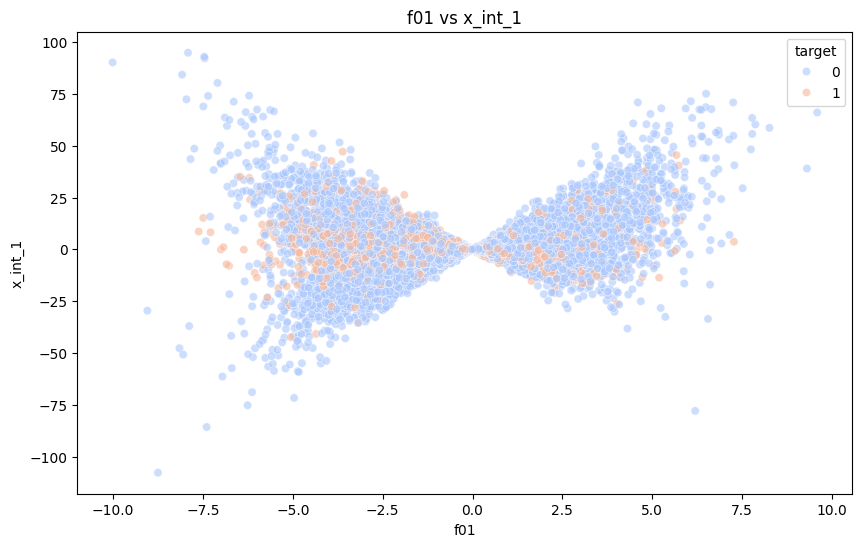

In [10]:
# Посмотрим, линейно ли разделяется задача при сравнении признаков f01 и x_int_1
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="f01",
    y="x_int_1",
    hue="target",
    alpha=0.6,
    palette="coolwarm"
)
plt.title("f01 vs x_int_1")
plt.show()

**Выводы базового EDA**

Размер датасета: 18000 строк и 39 столбцов.

Датасет содержит следующие стобцы:
- `id` - целое число от 1 до 18000, является идентификатором каждого признака;
- `f01-f35` - некоторые абстрактные признаки, вероятнее всего, зависимость взаимодействия близка к линейной;
- `x_int_1` и `x_int_2` - также признаки, но являются компонентами нелинейного взаимодействия;
- `target` - целевая переменная.

Пропущенных значений нет.

Дубликатов нет.

Описательные статистики показывают наличие большого количества шума и выбросов, однако для нашей цели - понимание работы ансамблей на практике - это даже плюс, так как ансамбли должны быть устойчивы к ним, когда как простые модели - нет.

У целевых классов очень большой дисбаланс (примерно **74%** к **26%**). Чрезвычайно важно произвести стратификацию.

Итак, целевая переменная - `target`, признаки - все, кроме `id`.

## 2. Train/Test и воспроизводимость

In [11]:
# Выделяем признаки и целевую переменную
X = df.drop(columns=["id", "target"], axis=1)  # признаки - все, кроме индексов и целевой переменной
y = df["target"]  # целевая переменная

X.shape, y.shape

((18000, 37), (18000,))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,  # стратификация, так как очень выраженный дисбаланс
    random_state=RANDOM_STATE
)

print("Размеры выборок:")
print("  train:", X_train.shape)
print("  test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
  train: (14400, 37)
  test:  (3600, 37)

Распределение классов (train):
target
0    0.737361
1    0.262639
Name: proportion, dtype: float64

Распределение классов (test):
target
0    0.7375
1    0.2625
Name: proportion, dtype: float64


**Почему важны стратификация и зерно?**

Если разделить данные случайно, без стратификации, то в обучающей выборке, допустим, 30% записей может иметь класс 1, а в то же самое время в тестовой выборке всего 10% займут записи класса 1. Это приведет к некорректной оценке качества (например, модель "кажется хорошей", потому что просто предсказывает 0).

Зерно важно фиксировать, так как каждый запуск даёт разные результаты без этой самой фиксации, то есть не выйдет сравнить две модели честно.

## 3. Baseline (Dummy и LogisticRegression)

In [13]:
estimator_dummy = DummyClassifier(
   strategy="most_frequent",
   random_state=RANDOM_STATE
)

estimator_dummy.fit(X, y)

y_test_pred_dummy = estimator_dummy.predict(X_test)
y_test_pred_proba_dummy = estimator_dummy.predict_proba(X_test)[:, 1]

In [14]:
# Пайплайн логистической регрессии
logistic_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "log_reg",
            LogisticRegression(
                random_state=RANDOM_STATE
            )
        )
    ]
)

In [15]:
# Существуют штрафы, которые поддерживают не все солверы, разделим их в решетчатом подборе гиперпараметрво
lr_param_grid = [
    {   # Штраф l2
        "log_reg__l1_ratio": [0],
        "log_reg__C": [0.01, 0.1, 1, 10, 100],
        "log_reg__solver": ["lbfgs", "newton-cg", "liblinear", "sag", "saga"],
        "log_reg__max_iter": [2500, 5000]
    },
    {   # Штраф l1
        "log_reg__l1_ratio": [1],
        "log_reg__C": [0.01, 0.1, 1, 10, 100],
        "log_reg__solver": ["liblinear", "saga"],
        "log_reg__max_iter": [2500, 5000]
    },
    {   # Штраф elasticnet
        "log_reg__l1_ratio": [0.2, 0.5, 0.8],
        "log_reg__C": [0.01, 0.1, 1, 10, 100],
        "log_reg__solver": ["saga"],
        "log_reg__max_iter": [2500, 5000]
    }
]

In [16]:
# Берем лучшую модель
search_lr = run_grid_search(
    "LR",
    logistic_pipeline,
    lr_param_grid,
    X_train,
    y_train
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.01, l1_ratio=0.5, max_iter=2500,
                                    random_state=42, solver='saga'))])


In [17]:
print("БЕЙЗЛАЙН DummyClassifier СО СТРАТЕГИЕЙ most_frequent\n")

print_metrics(y_test, y_test_pred_dummy, y_test_pred_proba_dummy)

БЕЙЗЛАЙН DummyClassifier СО СТРАТЕГИЕЙ most_frequent

Accuracy : 0.7375
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.5


In [18]:
print("РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ\n")

y_test_pred_lr = search_lr.predict(X_test)
y_test_pred_proba_lr = search_lr.predict_proba(X_test)[:, 1]

print_metrics(y_test, y_test_pred_lr, y_test_pred_proba_lr)

print("\nПодробный отчёт по классам (classification_report):")
print(classification_report(y_test, y_test_pred_lr))

РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

Accuracy : 0.8091666666666667
Precision: 0.7461832061068703
Recall   : 0.41375661375661377
F1-score : 0.5323349217154527
ROC-AUC  : 0.7985822895804062

Подробный отчёт по классам (classification_report):
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      2655
           1       0.75      0.41      0.53       945

    accuracy                           0.81      3600
   macro avg       0.78      0.68      0.71      3600
weighted avg       0.80      0.81      0.79      3600



In [19]:
# Сравним результаты наших бейзлайн моделей
results = pd.DataFrame({
    "Metrics": [
        "Accuracy",
        "Precision",
        "Recall",
        "F1-score",
        "ROC-AUC"
    ],
    "Dummy (most frequent)": compute_metrics(y_test, y_test_pred_dummy, y_test_pred_proba_dummy),
    "Logistic Regression": compute_metrics(y_test, y_test_pred_lr, y_test_pred_proba_lr)
})

# Рассчитаем прирост по сравнению с бейзлайном
results["Improvement"] = results["Logistic Regression"] - results["Dummy (most frequent)"]

results

,Metrics,Dummy (most frequent),Logistic Regression,Improvement
0,Accuracy,0.7375,0.809167,0.071667
1,Precision,0.0000,0.746183,0.746183
2,Recall,0.0000,0.413757,0.413757
3,F1-score,0.0000,0.532335,0.532335
4,ROC-AUC,0.5000,0.798582,0.298582


**Интерпретация результатов**

`DummyClassifier` выдает ожидаемый результат, соответствующий стратегии `most_frequent`. Этот классификатор просто предсказывает класс 0 для тестового набора. Напомним, что результаты любой хоть сколько-нибуль адекватной модели должны быть лучше представленных.

Логистическая регрессия `LogisticRegression`, несмотря на достаточно серьезный подбор гиперпараметров, находит **всего 41% истинных классов 1 среди тестовых данных** (метрика `recall`). И пусть по метрике `precision` показывает относительно неплохой результат, `f1-score` помогает убедиться в том, что модель демонстрирует лишь умеренное качество баланса между полнотой и точностью. При этом уровень `accuracy`, можно сказать, практически не изменился по сравнению с "глупой" моделью. По этой причине всегда необходимо смотреть несколько метрик.

Более содержательной оказывается метрика `ROC-AUC` (~0.8%). Она показывает, что модель способна умеренно хорошо разделять классы по уровню уверенности, несмотря на сильный шум и нелинейные взаимодействия в данных. Однако этот результат всё ещё отражает фундаментальное ограничение линейных моделей: они не могут эффективно моделировать сложные, нелинейные зависимости между признаками и целевой переменной.

Дополнительно отобразим ROC- и PR-кривые для созданных моделей.

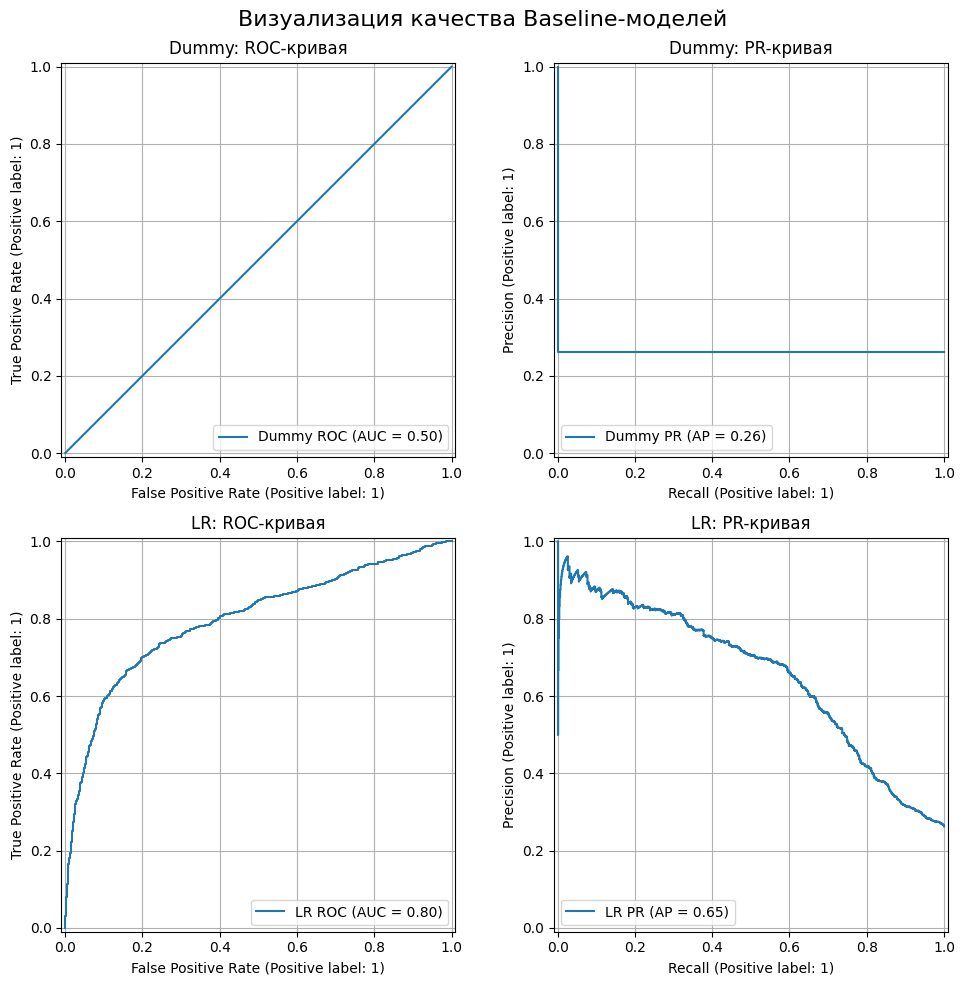

In [20]:
# Создаем фигуру с четырьмя подграфиками
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2,
    2,
    figsize=(10, 10)
)

# ROC- и PR-кривые для DummyClassifier
roc_and_pr_plot(y_test, y_test_pred_proba_dummy, ax1, ax2, "Dummy")
# И для LogisticRegression
roc_and_pr_plot(y_test, y_test_pred_proba_lr, ax3, ax4, "LR")

# Общее название
plt.suptitle("Визуализация качества Baseline-моделей", fontsize=16)

# Сохраняем изображение
fig.savefig("artifacts/figures/baseline.png")

plt.tight_layout()
plt.show()

Построенные графики подтверждают интерпретацию результатов выше.

## 4. Дерево решений и ансамбли

Теперь используем новые модели: **дерево решений** (`DecisionTreeClassifier`), **случайный лес** (`RandomForestClassifier`), **градиентный бустинг** (`GradientBoostingClassifier`) и **стекинг** (`StackingClassifier`).

### 4.1 Дерево решений

In [21]:
estimator_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_param_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01]
}

search_dt = run_grid_search(
    "DT",
    estimator_dt,
    dt_param_grid,
    X_train,
    y_train
)

y_test_pred_dt = search_dt.predict(X_test)
y_test_pred_proba_dt = search_dt.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 64 candidates, totalling 320 fits
DecisionTreeClassifier(max_depth=8, min_samples_leaf=20, random_state=42)


### 4.2 Случайный лес

In [22]:
estimator_rf = RandomForestClassifier(
    n_estimators=100,
    oob_score=False,
    random_state=RANDOM_STATE
)

rf_param_grid = {
    "max_depth": [3, 6, 10],
    "min_samples_leaf": [1, 5, 10]
}

search_rf = run_grid_search(
    "RF",
    estimator_rf,
    rf_param_grid,
    X_train,
    y_train
)

y_test_pred_rf = search_rf.predict(X_test)
y_test_pred_proba_rf = search_rf.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 9 candidates, totalling 45 fits
RandomForestClassifier(max_depth=10, random_state=42)


### 4.3 Градиентный бустинг

In [23]:
estimator_gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_param_grid = {
    "n_estimators": [50, 100],
    "learning_rate": [0.1, 0.2],
    "max_depth": [4, 5]
}

search_gb = run_grid_search(
    "GB",
    estimator_gb,
    gb_param_grid,
    X_train,
    y_train
)

y_test_pred_gb = search_gb.predict(X_test)
y_test_pred_proba_gb = search_gb.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GradientBoostingClassifier(learning_rate=0.2, max_depth=5, random_state=42)


### 4.4 Стекинг

In [24]:
estimators_stacking = [
    ("lr", search_lr.best_estimator_),
    ("rf", search_rf.best_estimator_),
    ("gb", search_gb.best_estimator_)
]

stack = StackingClassifier(
    estimators=estimators_stacking,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Стекинг обычно имеет мало “ручек”, поэтому без GridSearch – просто честная оценка
stack.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.The type of estimator is generally expected to be a classifier.However, one can pass a regressor for some use case (e.g. ordinalregression).","[('lr', ...), ('rf', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA classifier which will be used to combine the base estimators.The default classifier is a:class:`~sklearn.linear_model.LogisticRegression`.",LogisticRegre...ndom_state=42)
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",5
,"stack_method stack_method: {'auto', 'predict_proba', 'decision_function', 'predict'}, default='auto'Methods called for each base estimator. It can be:* if 'auto', it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.* otherwise, one of `'predict_proba'`, `'decision_function'` or `'predict'`. If the method is not implemented by the estimator, it will raise an error.",'auto'
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",-1
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a

In [25]:
y_test_pred_stack = stack.predict(X_test)
y_test_pred_proba_stack = stack.predict_proba(X_test)[:, 1]

# Также добавим в best_models
best_models["Stack"] = stack

In [26]:
final_results = pd.DataFrame({
    "Metrics": [
        "Accuracy",
        "Precision",
        "Recall",
        "F1-score",
        "ROC-AUC"
    ],
    "Dummy": compute_metrics(y_test, y_test_pred_dummy, y_test_pred_proba_dummy),
    "LR": compute_metrics(y_test, y_test_pred_lr, y_test_pred_proba_lr),
    "DT": compute_metrics(y_test, y_test_pred_dt, y_test_pred_proba_dt),
    "RF": compute_metrics(y_test, y_test_pred_rf, y_test_pred_proba_rf),
    "GB": compute_metrics(y_test, y_test_pred_gb, y_test_pred_proba_gb),
    "Stack": compute_metrics(y_test, y_test_pred_stack, y_test_pred_proba_stack)
})

final_results

,Metrics,Dummy,LR,DT,RF,GB,Stack
0,Accuracy,0.7375,0.809167,0.825278,0.866944,0.893889,0.903889
1,Precision,0.0000,0.746183,0.736527,0.905923,0.853199,0.858683
2,Recall,0.0000,0.413757,0.520635,0.550265,0.719577,0.758730
3,F1-score,0.0000,0.532335,0.610043,0.684661,0.780712,0.805618
4,ROC-AUC,0.5000,0.798582,0.826834,0.915102,0.925340,0.927987


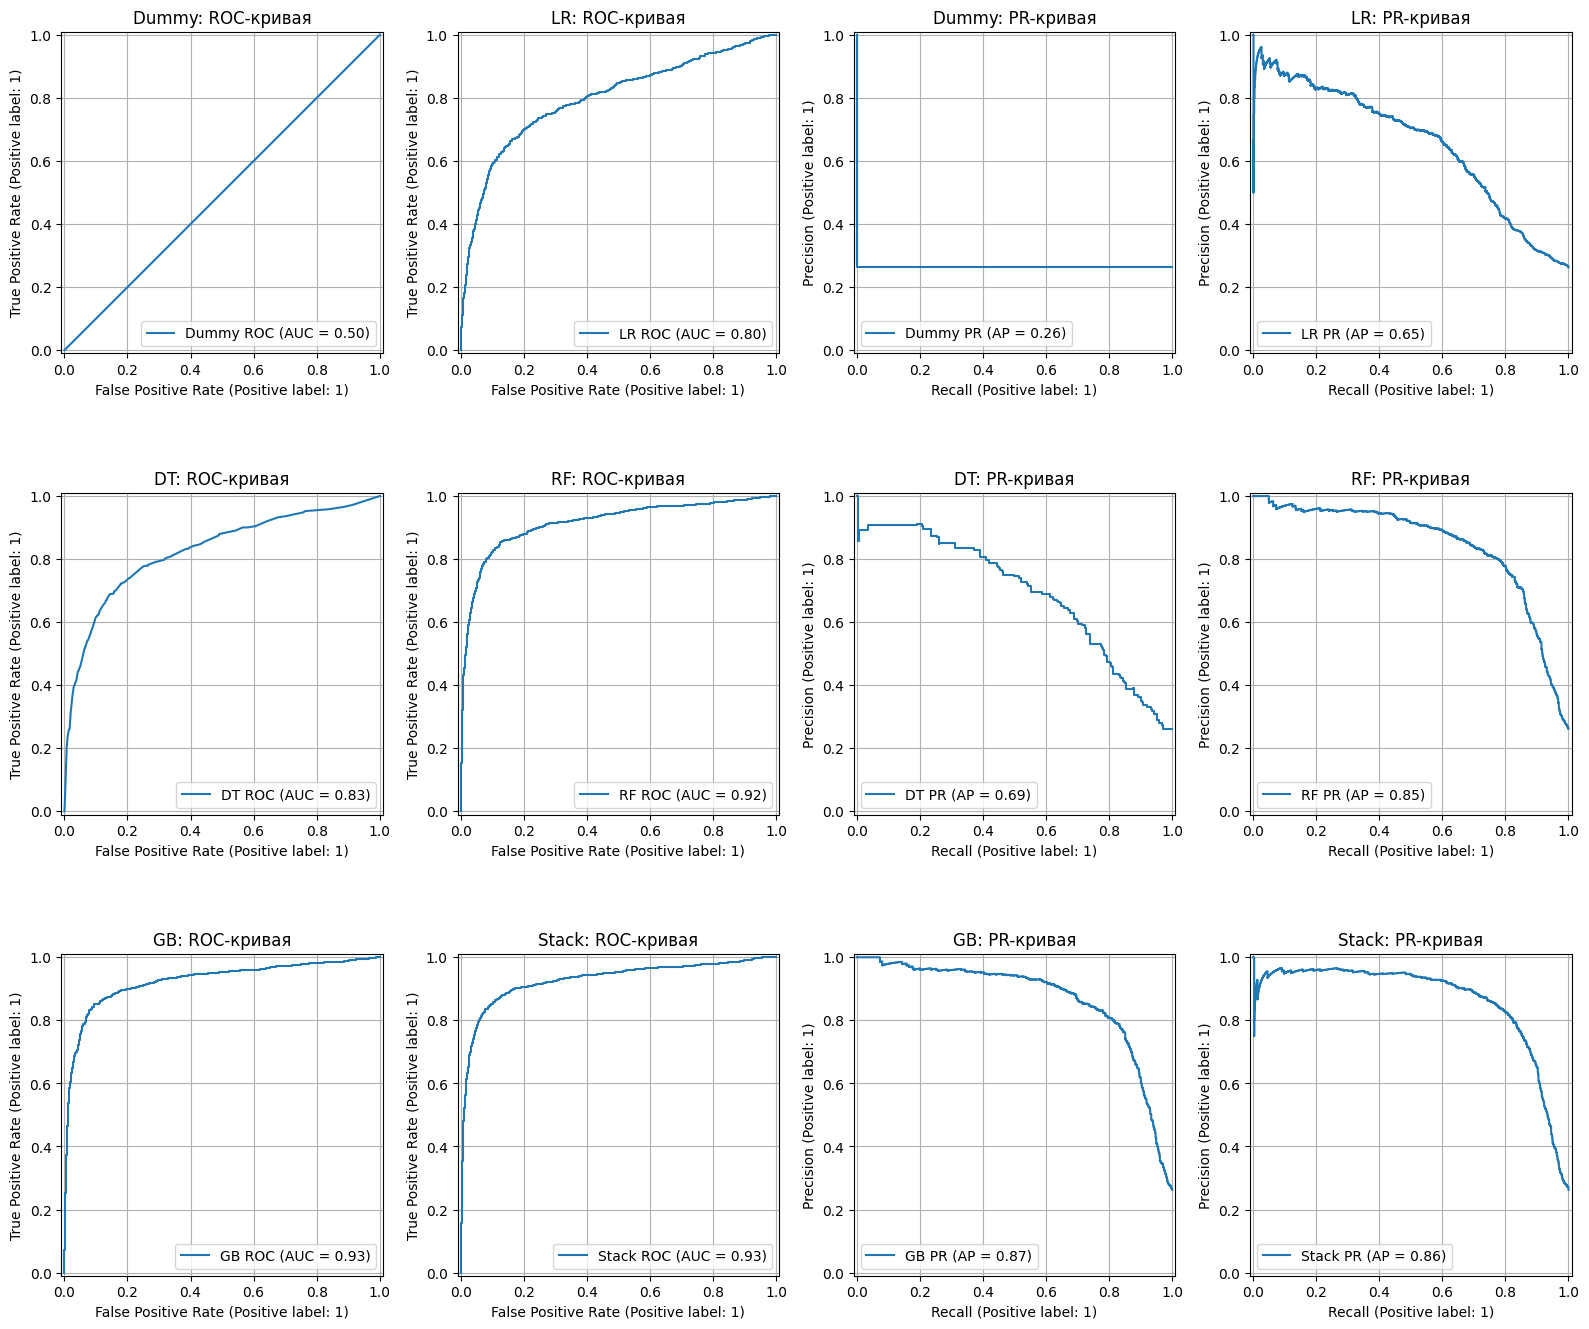

In [27]:
# Дополнительная визуализация для всех моделей, ROC- и PR-кривые
fig, axes = plt.subplots(3, 4, figsize=(16, 14))

# Список данных для каждой модели
models_data = [
    (y_test_pred_proba_dummy, "Dummy"),
    (y_test_pred_proba_lr, "LR"),
    (y_test_pred_proba_dt, "DT"),
    (y_test_pred_proba_rf, "RF"),
    (y_test_pred_proba_gb, "GB"),
    (y_test_pred_proba_stack, "Stack")
]

# Распределяем графики так, чтобы слева оказались все ROC-кривые, а справа - PR-кривые
for idx, (y_proba, name) in enumerate(models_data):
    row = idx // 2  # в каждой строке по две модели
    if idx % 2 == 0:  # первая модель в строке → столбцы 0 (ROC) и 2 (PR)
        roc_ax = axes[row, 0]  # столбец 0 для ROC
        pr_ax = axes[row, 2]   # и 2 для PR
    else:  # вторая модель
        roc_ax = axes[row, 1]  # столбец 1 для ROC
        pr_ax = axes[row, 3]   # и 3 для PR
    
    roc_and_pr_plot(y_test, y_proba, roc_ax, pr_ax, name)

# Сохраняем изображение
fig.savefig("artifacts/figures/all_models.png")

plt.tight_layout()
plt.show()

In [28]:
# Извлекаем строку ROC-AUC
roc_auc_scores = final_results.set_index("Metrics").loc["ROC-AUC"]

# Сортируем модели по убыванию ROC-AUC
sorted_models = roc_auc_scores.sort_values(ascending=False).index.tolist()

# Формируем новый порядок столбцов
final_results_sorted = final_results[["Metrics"] + sorted_models].copy()

final_results_sorted

,Metrics,Stack,GB,RF,DT,LR,Dummy
0,Accuracy,0.903889,0.893889,0.866944,0.825278,0.809167,0.7375
1,Precision,0.858683,0.853199,0.905923,0.736527,0.746183,0.0000
2,Recall,0.758730,0.719577,0.550265,0.520635,0.413757,0.0000
3,F1-score,0.805618,0.780712,0.684661,0.610043,0.532335,0.0000
4,ROC-AUC,0.927987,0.925340,0.915102,0.826834,0.798582,0.5000


In [29]:
# Собираем метрики по каждой модели в виде словаря
model_metrics = {}

# Функция для удобного вычисления всех метрик
def get_metrics_dict(y_true, y_pred, y_proba):
    return {
        "Accuracy": float(accuracy_score(y_true, y_pred)),
        "Precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "Recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "F1-score": float(f1_score(y_true, y_pred, zero_division=0)),
        "ROC-AUC": float(roc_auc_score(y_true, y_proba))
    }

# Заполняем метрики для каждой модели
model_metrics["Dummy"]  = get_metrics_dict(y_test, y_test_pred_dummy, y_test_pred_proba_dummy)
model_metrics["LR"]     = get_metrics_dict(y_test, y_test_pred_lr,     y_test_pred_proba_lr)
model_metrics["DT"]     = get_metrics_dict(y_test, y_test_pred_dt,     y_test_pred_proba_dt)
model_metrics["RF"]     = get_metrics_dict(y_test, y_test_pred_rf,     y_test_pred_proba_rf)
model_metrics["GB"]     = get_metrics_dict(y_test, y_test_pred_gb,     y_test_pred_proba_gb)
model_metrics["Stack"]  = get_metrics_dict(y_test, y_test_pred_stack,  y_test_pred_proba_stack)

# Сохраняем в правильном формате: объект на верхнем уровне
save_json(model_metrics, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts/metrics_test.json
Saved: artifacts/search_summaries.json


**Сравнение результатов**

Дерево решений `DecisionTreeClassifier` показывает заметное улучшение по сравнению с логистической регрессией: `recall` вырос до 52%, а `ROC-AUC` достиг 0.83. Это демонстрирует, что даже простая нелинейная модель способна лучше справляться со сложной структурой данных, включающей взаимодействия признаков. Однако дерево по-прежнему не использует преимущества агрегации — оно склонно к переобучению.

Существенный качественный скачок наблюдается при переходе к **ансамблевым методам**.

Случайный лес `RandomForestClassifier` демонстрирует высокую точность предсказаний (`precision` примерно 90.6%) и значительно улучшает как `F1-score` (0.68), так и `ROC-AUC` (0.915). Высокий показатель `precision` указывает на то, что модель крайне редко ошибается, когда предсказывает положительный класс. Однако её `recall` остаётся умеренным (55%), что говорит о том, что алгоритм предпочитает не рисковать ложно-положительными срабатываниями, тем самым жертвуя полнотой.

В свою очередь, градиентный бустинг `GradientBoostingClassifier` демонстрирует лучший баланс, по сравнению с случайным лесом: он находит уже 72% всех истинных положительных примеров (`recall`), при этом сохраняя высокую точность (`precision` 85.3%). Его `F1-score` (0.78) и `ROC-AUC` (0.925) являются наилучшими среди всех рассмотренных моделей, кроме стекинга. Это подтверждает, что последовательное исправление ошибок предыдущих деревьев позволяет эффективно улавливать сложные нелинейные паттерны, заложенные в датасете (даже искусственном).

Наконец, стекинг `StackingClassifier`, комбинирующий сильные стороны логистической регрессии, случайного леса и градиентного бустинга, достигает максимальных значений по всем ключевым метрикам:
- `ROC-AUC` = 0.928 — практически оптимальное ранжирование;
- `Recall` = 75.9% — модель уверенно выявляет подавляющее большинство объектов класса 1;
- `F1-score` = 0.805 — лучший баланс между полнотой и точностью.

Таким образом, эксперимент чётко подтверждает гипотезу, заложенную в структуру датасета: ансамблевые методы, особенно градиентный бустинг и стекинг, значительно превосходят базовые модели в условиях шума, перекрытия классов и нелинейных взаимодействий признаков. При этом стекинг демонстрирует, что даже на фоне мощных ансамблей возможно дополнительное улучшение за счёт разумной агрегации их предсказаний.

Дополнительно построены ROC- и PR-кривые для всех обученных моделей, чтобы визуально оценить качество ранжирования и поведение моделей при различных порогах.

## 5. Лучшая модель

Как уже ясно, **главной метрикой выбран ROC-AUC**, так как в датасете присутствует значительный дисбаланс классов; также подбор гиперпараметров производился с учетом именно этой метрики.

На основе ROC-AUC выберем лучшую модель, проведем ее диагностику (`confiusion matrix` и `permutation importance`) и сохраним.

In [30]:
best_model_name = final_results_sorted.columns[1]  # можно так сделать, так как сортировка проводилась по ROC-AUC

best_model = best_models[best_model_name]

print(best_model_name)

final_results[["Metrics", best_model_name]]

Stack


,Metrics,Stack
0,Accuracy,0.903889
1,Precision,0.858683
2,Recall,0.758730
3,F1-score,0.805618
4,ROC-AUC,0.927987


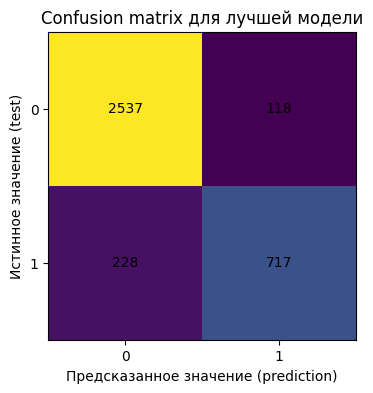

In [31]:
# Confusion matrix помогает понять тип ошибок (FP/FN)
y_pred_best = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 4))

plt.imshow(conf_matrix)
plt.title("Confusion matrix для лучшей модели")
plt.xlabel("Предсказанное значение (prediction)")
plt.ylabel("Истинное значение (test)")
plt.xticks([0, 1])
plt.yticks([0, 1])
for (i, j), v in np.ndenumerate(conf_matrix):
        plt.text(j, i, str(v), ha="center", va="center")

plt.savefig("artifacts/figures/confusion_matrix.png")
        
plt.show()

**Комментарий к матрице ошибок**

Модель очень редко ошибается на объектах класса 0, в то же время, 228 объектов класса 1 не были распознаны.

Таким образом, лучшая модель в большей степени склонна к ложно-отрицательным ошибкам, чем к ложно-положительным, что типично для задач с умеренным дисбалансом, где алгоритм осторожен в предсказании редкого класса.

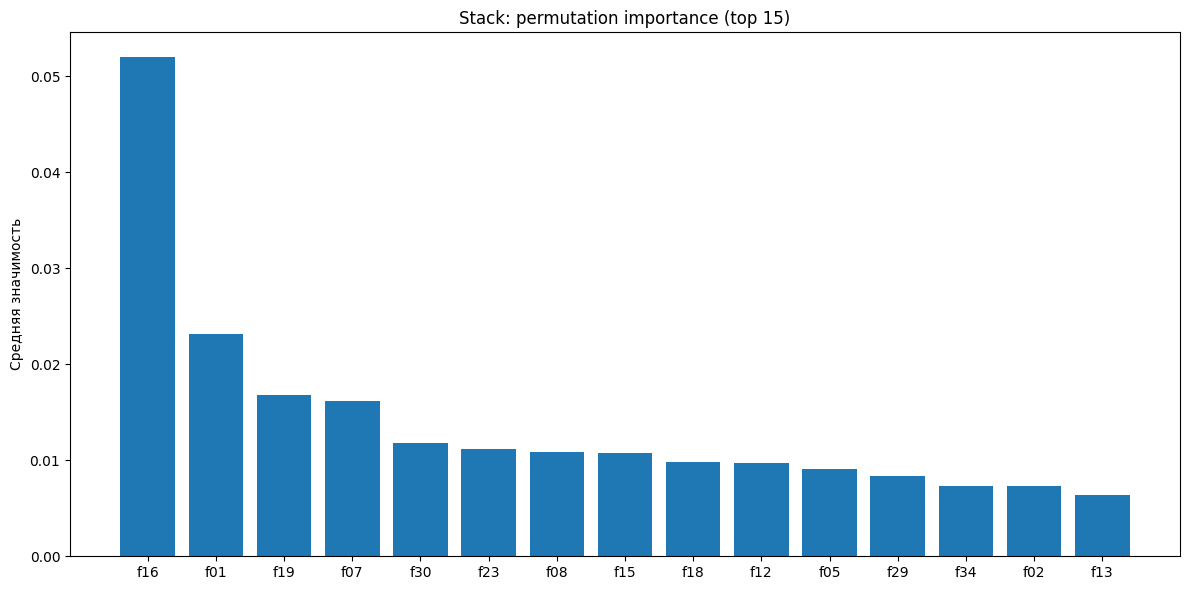

In [32]:
# Permutation importance (top 15) для лучшей модели
permutations = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    scoring="roc_auc"
)

imp = permutations.importances_mean
idx = np.argsort(imp)[::-1][:15]  # берем 15 индексов с наибольшим значением

plt.figure(figsize=(12, 6))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [list(X.columns)[i] for i in idx])
plt.ylabel(f"Средняя значимость")
plt.title(f"{best_model_name}: permutation importance (top 15)")

plt.savefig("artifacts/figures/permutation_importance.png")

plt.tight_layout()
plt.show()

Среди всех признаков значительно выделяется `f16`, он важен для модели больше всех остальных. Другие признаки практически не выделяются. Отметим лишь, что признаки-компоненты нелинейного взаимодействия `x_int_1` и `x_int_2` в списке 15 важнейших для стекинга признаков отсутствуют.

In [33]:
# Сохраним лучшую модель
joblib.dump(best_model, best_model_path)

meta = {
    "best_model_label": best_model_name,
    "test_metrics": final_results[["Metrics", best_model_name]].to_dict(),
    "search_summary": search_summaries.get(best_model_name, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, best_model_meta_path)

print("Saved:", best_model_path)
print("Saved:", best_model_meta_path)

Saved: artifacts/best_model.joblib
Saved: artifacts/best_model_meta.json


## 6. Вывод

Эксперимент подтвердил, что ансамблевые методы (`Random Forest`, `Gradient Boosting`, `Stacking`) значительно превосходят базовые модели (`Dummy`, `Logistic Regression`, `Decision Tree`) на синтетическом датасете с нелинейными взаимодействиями и шумом. Лучшей оказалась модель **стекинга** (ROC-AUC = 0.928), что демонстрирует эффективность композиции моделей в сложных задачах бинарной классификации.